<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/NY_baselineAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

New york state has reduced the Covid-19 cases. We have investigated the mask, social distancing, mobility data for NY state

In [110]:
!pip install wget


In [111]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import wget
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

## County Population

In [112]:
US_population_filename = wget.download('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')
county_population_US = pd.read_csv(US_population_filename,low_memory=False)
print(county_population_US.shape)

county_population_US.head(2)

(3195, 4)


,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869


In [113]:
ny_population = county_population_US[county_population_US['State'] == 'NY']
print(ny_population.shape)
ny_population.head(2)

(64, 4)


,countyFIPS,County Name,State,population
1861,0,Statewide Unallocated,NY,0
1862,0,New York City Unallocated,NY,0


In [114]:
ny_population['County Name'].unique()

array(['Statewide Unallocated', 'New York City Unallocated',
       'Albany County', 'Allegany County', 'Bronx County',
       'Broome County', 'Cattaraugus County', 'Cayuga County',
       'Chautauqua County', 'Chemung County', 'Chenango County',
       'Clinton County', 'Columbia County', 'Cortland County',
       'Delaware County', 'Dutchess County', 'Erie County',
       'Essex County', 'Franklin County', 'Fulton County',
       'Genesee County', 'Greene County', 'Hamilton County',
       'Herkimer County', 'Jefferson County', 'Kings County',
       'Lewis County', 'Livingston County', 'Madison County',
       'Monroe County', 'Montgomery County', 'Nassau County',
       'New York County', 'Niagara County', 'Oneida County',
       'Onondaga County', 'Ontario County', 'Orange County',
       'Orleans County', 'Oswego County', 'Otsego County',
       'Putnam County', 'Queens County', 'Rensselaer County',
       'Richmond County', 'Rockland County', 'St. Lawrence County',
       'Sara

In [115]:
queens_county_population = ny_population[ny_population['County Name'] == 'Queens County']
queens_county_population

,countyFIPS,County Name,State,population
1903,36081,Queens County,NY,2253858


## Land Area 

In [116]:
landarea_filename = wget.download('https://raw.githubusercontent.com/ykzeng/covid-19/master/data/census-landarea-all.csv')
landarea_data = pd.read_csv(landarea_filename,low_memory=False)
print(landarea_data.shape)


(3195, 52)


In [117]:
landarea_data.head(2)

,fips,PST045212,PST040210,PST120212,POP010210,AGE135212,AGE295212,AGE775212,SEX255212,RHI125212,RHI225212,RHI325212,RHI425212,RHI525212,RHI625212,RHI725212,RHI825212,POP715211,POP645211,POP815211,EDU635211,EDU685211,VET605211,LFE305211,HSG010211,HSG445211,HSG096211,HSG495211,HSD410211,HSD310211,INC910211,INC110211,PVY020211,BZA010211,BZA110211,BZA115211,NES010211,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030212,LND110210,POP060210
0,0,313914040,308747508,1.7,308745538,6.4,23.5,13.7,50.8,77.9,13.1,1.2,5.1,0.2,2.4,16.9,63.0,84.6,12.8,20.3,85.4,28.2,22215303,25.4,132312404,66.1,25.9,186200,114761359,2.60,27915,52762,14.3,7354043,113425965,1.3,22491080,27092908,7.1,0.9,5.7,0.1,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,829658,3531905.43,87.4
1,1000,4822023,4779745,0.9,4779736,6.3,23.3,14.5,51.5,70.0,26.5,0.7,1.2,0.1,1.5,4.1,66.6,84.5,3.4,5.0,81.9,22.0,403982,24.0,2182088,70.7,15.5,120800,1831269,2.53,23483,42934,17.6,97743,1573138,0.3,321641,382350,14.8,0.8,1.8,0.1,1.2,28.1,112858843,52252752,57344851,12364,6426342,13506,50645.33,94.4


In [118]:
landarea_data['fips'].unique()

array([    0,  1000,  1001, ..., 56041, 56043, 56045])

In [119]:
#LND110210

landarea_data[landarea_data['fips'] == 36081]['LND110210']

1902    108.53
Name: LND110210, dtype: float64

#### Population density

In [120]:
density = 2253858/108.53

density

20767.142725513684

Queens population density

In [193]:
queens_population_density=pd.merge(queens_county_population,landarea_data,how='inner', left_on=['countyFIPS'], right_on = ['fips'])

In [196]:
queens_population_density['population_density']= queens_population_density['population']/queens_population_density['LND110210']
queens_population_density = queens_population_density[['fips','County Name', 'State', 'population','LND110210','population_density']].copy()
queens_population_density.tail(3)

,fips,County Name,State,population,LND110210,population_density
0,36081,Queens County,NY,2253858,108.53,20767.142726


## Mask data

In [121]:
mask_filename = wget.download('https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv')
mask_filename

'mask-use-by-county (1).csv'

In [122]:

mask_data = pd.read_csv(mask_filename,low_memory=False)
print(mask_data.shape)

(3142, 6)


In [123]:
mask_data.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


In [124]:
mask_data[mask_data['COUNTYFP'] == 36081]

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1868,36081,0.022,0.023,0.068,0.136,0.751


In [125]:
0.022 +	0.023	+0.068	+0.136+	0.751

1.0

## Mobility Data 

### Google mobility data

In [126]:
google_data_url = 'https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/google_reports/mobility_report_US.csv'

google_filename = wget.download(google_data_url)
google_mobility_data = pd.read_csv(google_filename,low_memory=False)
google_mobility_data.head(2)

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential
0,Total,Total,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,Total,Total,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0


In [127]:
NY_GoogleMobility_data = google_mobility_data[google_mobility_data['state'] == 'New York']
print(NY_GoogleMobility_data.shape)
NY_GoogleMobility_data.tail(2)

(11098, 9)


,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential
284597,New York,Yates County,2020-08-10,NaN,34.0,NaN,NaN,-24.0,NaN
284598,New York,Yates County,2020-08-11,NaN,30.0,NaN,NaN,-24.0,NaN


### Apple mobility data

In [128]:
apple_report_url = 'https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/apple_reports/apple_mobility_report_US.csv'

apple_filename = wget.download(apple_report_url)
apple_mobility_data = pd.read_csv(apple_filename,low_memory=False)
apple_mobility_data.tail(2)

,state,county_and_city,geo_type,date,driving,transit,walking
478270,Wyoming,Uinta County,county,2020-08-12,268.83,NaN,NaN
478271,Wyoming,Uinta County,county,2020-08-13,315.41,NaN,NaN


In [129]:
NY_AppleMobility_data = apple_mobility_data[apple_mobility_data['state'] == 'New York']
print(NY_AppleMobility_data.shape)
NY_AppleMobility_data.tail(2)

(14204, 7)


,state,county_and_city,geo_type,date,driving,transit,walking
275810,New York,Yates County,county,2020-08-12,290.56,NaN,NaN
275811,New York,Yates County,county,2020-08-13,303.29,NaN,NaN


In [130]:
NY_AppleMobility_data['county'] = NY_AppleMobility_data['county_and_city']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [131]:
NY_AppleMobility_data = NY_AppleMobility_data[['state','county','date','driving','transit','walking']]

NY_AppleMobility_data.tail(2)

,state,county,date,driving,transit,walking
275810,New York,Yates County,2020-08-12,290.56,NaN,NaN
275811,New York,Yates County,2020-08-13,303.29,NaN,NaN


In [132]:
NY_mobility_data = pd.merge(NY_GoogleMobility_data,NY_AppleMobility_data,how='outer' ,on=['state','county','date'])
NY_mobility_data.shape

(14328, 12)

In [133]:
NY_mobility_data = NY_mobility_data.fillna(0)
NY_mobility_data.tail()

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
14323,New York,Yates County,2020-02-12,0.0,0.0,0.0,0.0,0.0,0.0,33.30,0.0,0.0
14324,New York,Yates County,2020-02-13,0.0,0.0,0.0,0.0,0.0,0.0,30.28,0.0,0.0
14325,New York,Yates County,2020-02-14,0.0,0.0,0.0,0.0,0.0,0.0,78.01,0.0,0.0
14326,New York,Yates County,2020-08-12,0.0,0.0,0.0,0.0,0.0,0.0,290.56,0.0,0.0
14327,New York,Yates County,2020-08-13,0.0,0.0,0.0,0.0,0.0,0.0,303.29,0.0,0.0


### Queens county mobility data

In [134]:
queens_mobility_data = NY_mobility_data[NY_mobility_data['county'] == 'Queens County']
print(queens_mobility_data.shape)
queens_mobility_data.tail()

(214, 12)


,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
13129,New York,Queens County,2020-02-12,0.0,0.0,0.0,0.0,0.0,0.0,3.27,0.0,0.0
13130,New York,Queens County,2020-02-13,0.0,0.0,0.0,0.0,0.0,0.0,14.60,0.0,0.0
13131,New York,Queens County,2020-02-14,0.0,0.0,0.0,0.0,0.0,0.0,34.10,0.0,0.0
13132,New York,Queens County,2020-08-12,0.0,0.0,0.0,0.0,0.0,0.0,26.37,0.0,0.0
13133,New York,Queens County,2020-08-13,0.0,0.0,0.0,0.0,0.0,0.0,26.34,0.0,0.0


In [135]:
queens_mobility_data.head()

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
7160,New York,Queens County,2020-02-15,-2.0,-5.0,-11.0,-5.0,2.0,0.0,15.43,0.0,0.0
7161,New York,Queens County,2020-02-16,1.0,-5.0,5.0,-5.0,-1.0,-1.0,-2.23,0.0,0.0
7162,New York,Queens County,2020-02-17,7.0,0.0,39.0,-16.0,-38.0,10.0,1.85,0.0,0.0
7163,New York,Queens County,2020-02-18,0.0,-4.0,-7.0,-5.0,-9.0,3.0,4.02,0.0,0.0
7164,New York,Queens County,2020-02-19,3.0,-2.0,14.0,-5.0,-9.0,2.0,5.73,0.0,0.0


## Social Distancing metric 

In [136]:
socialdistancing_url = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'

socialdistancing_file = wget.download(socialdistancing_url)
socialdistancing_data = pd.read_csv(socialdistancing_file,low_memory=False)
socialdistancing_data.tail(2)



,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
437898,2020-08-10,US,2,Wyoming,Uinta County,56041.0,699,5.901,188
437899,2020-08-11,US,2,Wyoming,Uinta County,56041.0,722,5.796,185


In [137]:
newyork_socialdistancing_data= socialdistancing_data[(socialdistancing_data['admin1']=='New York') &
                                           (socialdistancing_data['admin_level']== 2)]

newyork_socialdistancing_data.head()

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
254507,2020-03-01,US,2,New York,Albany County,36001.0,4095,2.616,54
254508,2020-03-02,US,2,New York,Albany County,36001.0,4376,4.680,97
254509,2020-03-03,US,2,New York,Albany County,36001.0,4686,4.778,100
254510,2020-03-04,US,2,New York,Albany County,36001.0,4842,4.486,93
254511,2020-03-05,US,2,New York,Albany County,36001.0,4548,5.129,107


In [138]:
queens_social_distancing = newyork_socialdistancing_data[newyork_socialdistancing_data['admin2'] == 'Queens County']
print(queens_social_distancing.shape)
queens_social_distancing.head()

(162, 9)


,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
260825,2020-03-01,US,2,New York,Queens County,36081.0,26218,1.339,35
260826,2020-03-02,US,2,New York,Queens County,36081.0,27435,3.813,99
260827,2020-03-03,US,2,New York,Queens County,36081.0,28459,3.747,98
260828,2020-03-04,US,2,New York,Queens County,36081.0,29480,3.822,99
260829,2020-03-05,US,2,New York,Queens County,36081.0,27602,4.052,106


# Load Data

In [139]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
!ls /content/drive/'Shared drives'/'CMPE 295- Master Project'/Covid19-data

CA_Covid-19.csv  NY_Covid-19.csv  Queens_county.csv


In [141]:
queens_covidcases = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Queens_county.csv', low_memory =False)
queens_covidcases.tail()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
201,8/5/20,New York,36081.0,0,0,636,29
202,8/6/20,New York,36081.0,0,0,703,2
203,8/7/20,New York,36081.0,0,0,714,4
204,8/8/20,New York,36081.0,0,0,703,8
205,8/9/20,New York,36081.0,0,0,515,6


## Fix Date

In [142]:
def fixDate(x):
  arr = x.split('/')
  m = arr[0]
  d = arr[1]
  y = arr[2]

  if int(m) < 10:
    m = '0'+str(m)
  if int(d) < 10:
    d = '0'+str(d)
  return '20'+y+'-'+m+'-'+d

In [143]:
queens_covidcases['Date'] = queens_covidcases['Date'].apply(lambda x: fixDate(x))
queens_covidcases.reset_index(drop=True)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
0,2020-01-22,New York,36081.0,0,0,0,0
1,2020-01-23,New York,36081.0,0,0,0,0
2,2020-01-24,New York,36081.0,0,0,0,0
3,2020-01-25,New York,36081.0,0,0,0,0
4,2020-01-26,New York,36081.0,0,0,0,0
...,...,...,...,...,...,...,...
201,2020-08-05,New York,36081.0,0,0,636,29
202,2020-08-06,New York,36081.0,0,0,703,2
203,2020-08-07,New York,36081.0,0,0,714,4
204,2020-08-08,New York,36081.0,0,0,703,8


# Formula Computation from Baseline Value

## For Social Distancing Metric

In [144]:
start_date = '2020-05-05'
end_date = '2020-05-13'
#start_date = '2020-02-17'
#end_date = '2020-03-07'
mask = (queens_social_distancing['date'] >= start_date) & (queens_social_distancing['date'] <= end_date)

In [145]:
df_queens_social_distancing =  queens_social_distancing.loc[mask]
df_queens_social_distancing

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
260889,2020-05-05,US,2,New York,Queens County,36081.0,26633,0.021,0
260890,2020-05-06,US,2,New York,Queens County,36081.0,27819,0.020,0
260891,2020-05-07,US,2,New York,Queens County,36081.0,29651,0.022,0
260892,2020-05-08,US,2,New York,Queens County,36081.0,27390,0.019,0
260893,2020-05-09,US,2,New York,Queens County,36081.0,27340,0.017,0
260894,2020-05-10,US,2,New York,Queens County,36081.0,27660,0.017,0
260895,2020-05-11,US,2,New York,Queens County,36081.0,27697,0.017,0
260896,2020-05-12,US,2,New York,Queens County,36081.0,29950,0.021,0
260897,2020-05-13,US,2,New York,Queens County,36081.0,28052,0.020,0


In [146]:
queens_social_distancing_base = (
    df_queens_social_distancing
    .pipe(lambda x: x.assign(gains_pctg=x["m50"]))
    .groupby(['admin1','admin2','fips'])
    .agg({"gains_pctg": "median"})
    .reset_index()
    .rename(columns={"gains_pctg": "m50"})
)
queens_social_distancing_base

,admin1,admin2,fips,m50
0,New York,Queens County,36081.0,0.02


In [147]:
queens_social_distancing_base.at[0,'m50']

0.02

computing formula : m50_baseline = 100 * m50/queens_social_distancing_base.at[0,'m50']

In [148]:
socialdistancing_data['m50_baseline'] = socialdistancing_data['m50'].apply(lambda x: 100 * (x/queens_social_distancing_base.at[0,'m50']))


In [149]:
socialdistancing_data[socialdistancing_data['admin1'] == 'California']

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index,m50_baseline
26590,2020-03-01,US,1,California,NaN,6.0,451282,4.122,60,20610.0
26591,2020-03-02,US,1,California,NaN,6.0,457175,6.725,98,33625.0
26592,2020-03-03,US,1,California,NaN,6.0,472598,6.842,100,34210.0
26593,2020-03-04,US,1,California,NaN,6.0,481255,6.827,99,34135.0
26594,2020-03-05,US,1,California,NaN,6.0,458159,7.270,106,36350.0
...,...,...,...,...,...,...,...,...,...,...
35425,2020-08-07,US,2,California,Yuba County,6115.0,1260,5.792,61,28960.0
35426,2020-08-08,US,2,California,Yuba County,6115.0,1183,3.720,39,18600.0
35427,2020-08-09,US,2,California,Yuba County,6115.0,1231,1.465,15,7325.0
35428,2020-08-10,US,2,California,Yuba County,6115.0,1297,4.869,51,24345.0


# Rolling Average for Social Distancing

In [150]:
queens_social_distancing = newyork_socialdistancing_data[newyork_socialdistancing_data['admin2'] == 'Queens County']
queens_social_distancing.head(3)

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
260825,2020-03-01,US,2,New York,Queens County,36081.0,26218,1.339,35
260826,2020-03-02,US,2,New York,Queens County,36081.0,27435,3.813,99
260827,2020-03-03,US,2,New York,Queens County,36081.0,28459,3.747,98


In [151]:
queens_social_distancing.iloc[:,8]

260825     35
260826     99
260827     98
260828     99
260829    106
         ... 
260982     22
260983     18
260984      5
260985     21
260986     22
Name: m50_index, Length: 162, dtype: int64

In [152]:
import pandas as pd
import altair as alt

base_queens = alt.Chart(queens_social_distancing).mark_bar().encode(
    x='monthdate(date):O',
).properties(
    width=500
)

In [153]:
base_queens.encode(y="m50_index").properties(title='Queens County Social Distancing Mteric(m50_index)')

alt.Chart(...)

In [154]:
queens_social_distancing['rolling_average'] = queens_social_distancing.iloc[:,8].rolling(window=7).mean()

base_queens = alt.Chart(queens_social_distancing).mark_bar().encode(
    x='monthdate(date):O',
).properties(
    width=500
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [155]:
queens_social_distancing.tail(10)

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index,rolling_average
260977,2020-08-02,US,2,New York,Queens County,36081.0,39110,0.062,1,14.000000
260978,2020-08-03,US,2,New York,Queens County,36081.0,39985,0.601,15,14.857143
260979,2020-08-04,US,2,New York,Queens County,36081.0,39689,0.171,4,13.285714
260980,2020-08-05,US,2,New York,Queens County,36081.0,36554,0.906,23,14.285714
260981,2020-08-06,US,2,New York,Queens County,36081.0,40105,0.789,20,14.571429
260982,2020-08-07,US,2,New York,Queens County,36081.0,37762,0.857,22,14.857143
260983,2020-08-08,US,2,New York,Queens County,36081.0,32671,0.714,18,14.714286
260984,2020-08-09,US,2,New York,Queens County,36081.0,33830,0.221,5,15.285714
260985,2020-08-10,US,2,New York,Queens County,36081.0,36840,0.825,21,16.142857
260986,2020-08-11,US,2,New York,Queens County,36081.0,37263,0.850,22,18.714286


In [156]:
base_queens.encode(y="rolling_average").properties(title='Queens County- 7 day rolling average (Social Distancing Metric)')


alt.Chart(...)

In [157]:
bar = base_queens.mark_bar().encode(y="m50_index")

line =  base_queens.mark_line(color='red').encode(
    y='rolling_average'
)

(bar + line).properties(title='Queens County - Social Distancing Metric and rolling average ',width=600)|base_queens.encode(y="rolling_average").properties(title='Queens County- 7 day rolling average (Social Distancing Metric)')

alt.HConcatChart(...)

## Overlap PLot

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

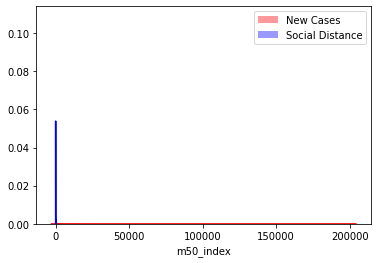

In [159]:
# Method 1: on the same Axis
sns.distplot( queens_covidcases["New cases"] , color="red", label="New Cases")
sns.distplot( (queens_social_distancing["m50_index"]) , color="blue", label="Social Distance")
plt.legend()
 
plt.show()

# Merge Social Distancing and 'New Cases'

In [160]:
merged_socialDistancing = pd.merge(queens_covidcases,queens_social_distancing,how='inner', left_on=['Date'], right_on = ['date'])

In [161]:
merged_socialDistancing.tail()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index,rolling_average
157,2020-08-05,New York,36081.0,0,0,636,29,2020-08-05,US,2,New York,Queens County,36081.0,36554,0.906,23,14.285714
158,2020-08-06,New York,36081.0,0,0,703,2,2020-08-06,US,2,New York,Queens County,36081.0,40105,0.789,20,14.571429
159,2020-08-07,New York,36081.0,0,0,714,4,2020-08-07,US,2,New York,Queens County,36081.0,37762,0.857,22,14.857143
160,2020-08-08,New York,36081.0,0,0,703,8,2020-08-08,US,2,New York,Queens County,36081.0,32671,0.714,18,14.714286
161,2020-08-09,New York,36081.0,0,0,515,6,2020-08-09,US,2,New York,Queens County,36081.0,33830,0.221,5,15.285714


In [162]:
merged_socialDistancing['m50_multiplied'] = merged_socialDistancing['m50_index'] * 1000

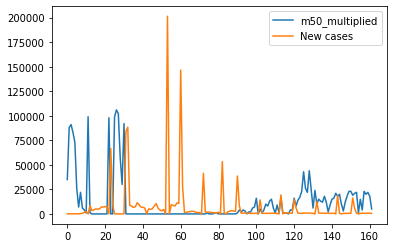

In [163]:
merged_socialDistancing[['m50_multiplied','New cases']].plot()

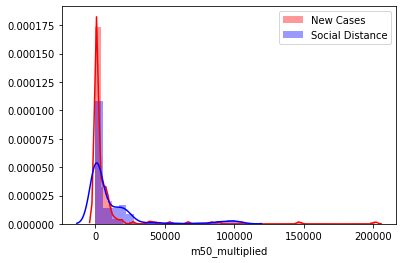

In [164]:
# Method 1: on the same Axis
sns.distplot( merged_socialDistancing["New cases"] , color="red", label="New Cases")
sns.distplot( (merged_socialDistancing["m50_multiplied"]) , color="blue", label="Social Distance")
plt.legend()
 
plt.show()

In [165]:
## Moving avg

merged_socialDistancing['rolling_avg_newcases'] = merged_socialDistancing.iloc[:,5].rolling(window=7).mean() 

In [166]:
merged_socialDistancing['rolling_average_multiplies'] = merged_socialDistancing['rolling_average'] * 1000

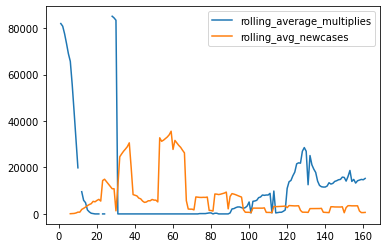

In [167]:
merged_socialDistancing[['rolling_average_multiplies','rolling_avg_newcases']].plot()

## Twin plot

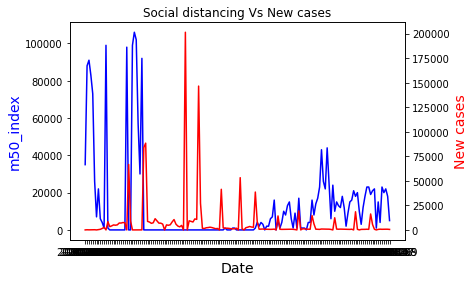

In [168]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_socialDistancing.date, merged_socialDistancing.m50_multiplied, color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("m50_index",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_socialDistancing.date, merged_socialDistancing["New cases"],color="red")
ax2.set_ylabel("New cases",color="red",fontsize=14)
plt.title("Social distancing Vs New cases")

plt.show()

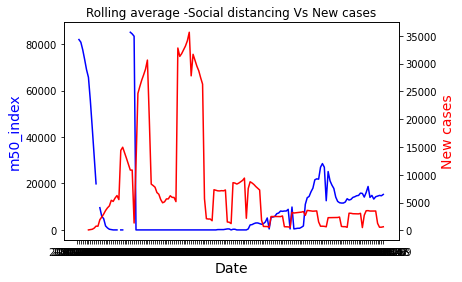

In [169]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_socialDistancing.date, merged_socialDistancing.rolling_average_multiplies, color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("m50_index",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_socialDistancing.date, merged_socialDistancing["rolling_avg_newcases"],color="red")
ax2.set_ylabel("New cases",color="red",fontsize=14)
plt.title("Rolling average -Social distancing Vs New cases")
plt.show()

## Correlation

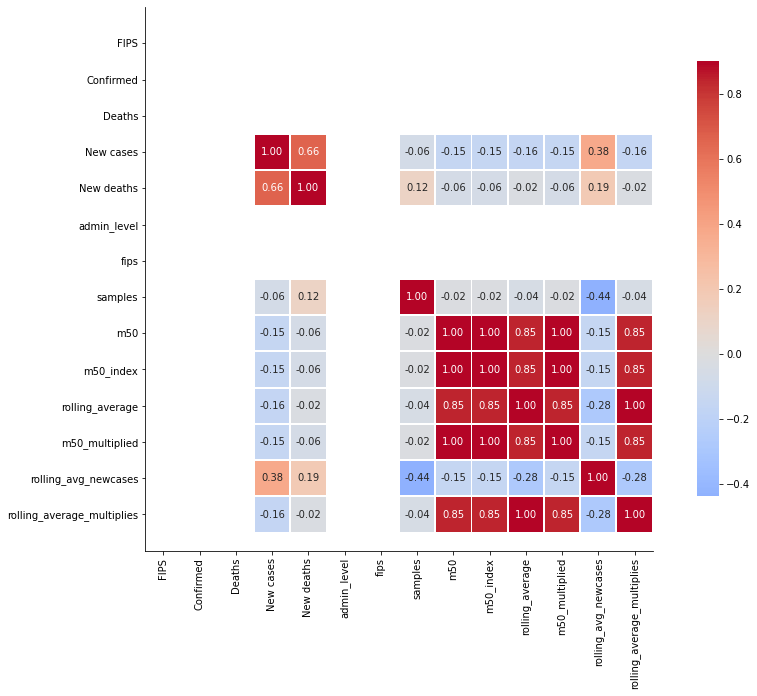

In [170]:
corr = merged_socialDistancing.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=.9, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

# Merge Social Distancing and mobility data

In [171]:
queens_mobility_data.head()

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
7160,New York,Queens County,2020-02-15,-2.0,-5.0,-11.0,-5.0,2.0,0.0,15.43,0.0,0.0
7161,New York,Queens County,2020-02-16,1.0,-5.0,5.0,-5.0,-1.0,-1.0,-2.23,0.0,0.0
7162,New York,Queens County,2020-02-17,7.0,0.0,39.0,-16.0,-38.0,10.0,1.85,0.0,0.0
7163,New York,Queens County,2020-02-18,0.0,-4.0,-7.0,-5.0,-9.0,3.0,4.02,0.0,0.0
7164,New York,Queens County,2020-02-19,3.0,-2.0,14.0,-5.0,-9.0,2.0,5.73,0.0,0.0


In [172]:
queens_covidcases.head()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
0,2020-01-22,New York,36081.0,0,0,0,0
1,2020-01-23,New York,36081.0,0,0,0,0
2,2020-01-24,New York,36081.0,0,0,0,0
3,2020-01-25,New York,36081.0,0,0,0,0
4,2020-01-26,New York,36081.0,0,0,0,0


In [173]:
merged_mobility = pd.merge(queens_covidcases,queens_mobility_data,how='inner', left_on=['Date'], right_on = ['date'])

merged_mobility.head()


,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
0,2020-01-22,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,1.02,0.0,0.0
1,2020-01-23,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,5.10,0.0,0.0
2,2020-01-24,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,19.35,0.0,0.0
3,2020-01-25,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,8.11,0.0,0.0
4,2020-01-26,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,-9.16,0.0,0.0


## Twin plot

### Retail and Recreation Vs new cases

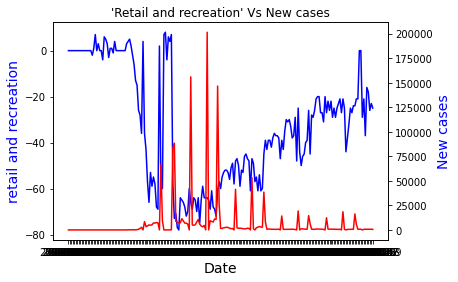

In [174]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['retail and recreation'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("retail and recreation",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'Retail and recreation' Vs New cases")

plt.show()

### Residential Vs New cases

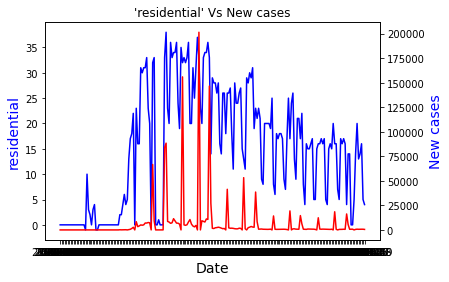

In [175]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['residential'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("residential",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'residential' Vs New cases")

plt.show()

### Workplaces Vs New cases

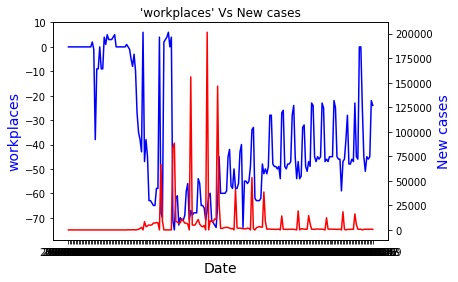

In [176]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['workplaces'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("workplaces",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'workplaces' Vs New cases")

plt.show()

### 'grocery and pharmacy' Vs New Cases

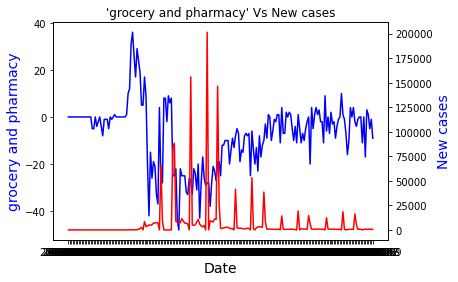

In [177]:


fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['grocery and pharmacy'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("grocery and pharmacy",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'grocery and pharmacy' Vs New cases")

plt.show()

### parks Vs New cases

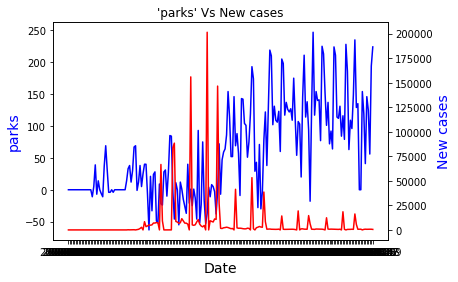

In [178]:

fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['parks'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("parks",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'parks' Vs New cases")

plt.show()

### 'transit stations' Vs New cases

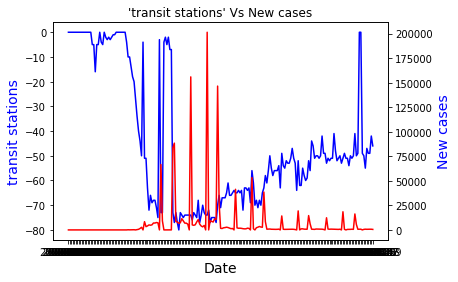

In [179]:

fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['transit stations'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("transit stations",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'transit stations' Vs New cases")

plt.show()

### Driving Vs New cases

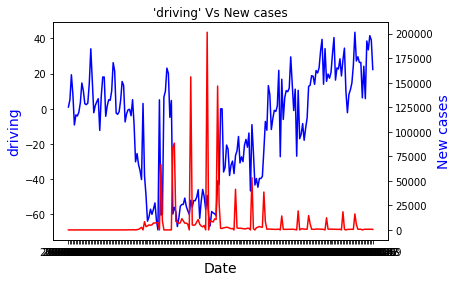

In [180]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['driving'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("driving",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'driving' Vs New cases")

plt.show()

### transit Vs New cases

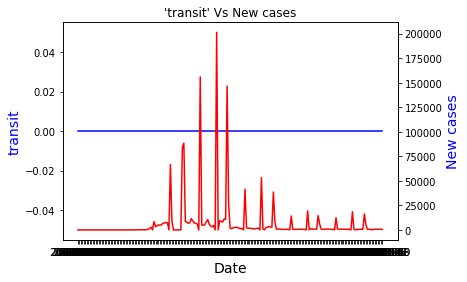

In [181]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['transit'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("transit",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'transit' Vs New cases")

plt.show()

### walking Vs New cases

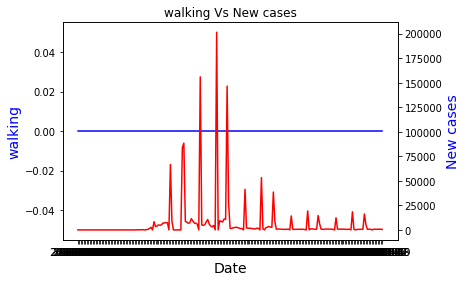

In [182]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['walking'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("walking",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("walking Vs New cases")

plt.show()

# Merge Social Distancing, mobility data and Covid Cases

In [188]:
merged_mobility.tail(1)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
204,2020-08-09,New York,36081.0,0,0,515,6,New York,Queens County,2020-08-09,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,0.0,0.0


In [223]:
merged_mobility_social_covid=pd.merge(merged_mobility,queens_social_distancing,how='inner', left_on=['Date','county'], right_on = ['date','admin2'])

In [214]:
merged_mobility_social_covid.tail(3)


,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,date_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,date_y,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index,rolling_average
159,2020-08-07,New York,36081.0,0,0,714,4,New York,Queens County,2020-08-07,-26.0,-5.0,56.0,-49.0,-45.0,16.0,41.58,0.0,0.0,2020-08-07,US,2,New York,Queens County,36081.0,37762,0.857,22,14.857143
160,2020-08-08,New York,36081.0,0,0,703,8,New York,Queens County,2020-08-08,-23.0,-1.0,194.0,-42.0,-22.0,5.0,39.14,0.0,0.0,2020-08-08,US,2,New York,Queens County,36081.0,32671,0.714,18,14.714286
161,2020-08-09,New York,36081.0,0,0,515,6,New York,Queens County,2020-08-09,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,0.0,0.0,2020-08-09,US,2,New York,Queens County,36081.0,33830,0.221,5,15.285714


# Merge Social Distancing, mobility data, Covid Cases, Population Density

In [215]:
queens_population_density

,fips,County Name,State,population,LND110210,population_density
0,36081,Queens County,NY,2253858,108.53,20767.142726


In [224]:
merged_mobility_social_covid = pd.merge(merged_mobility_social_covid,queens_population_density,how='inner', left_on=['county'], right_on = ['County Name'])

In [225]:
merged_mobility_social_covid.tail(1)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,date_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,date_y,country_code,admin_level,admin1,admin2,fips_x,samples,m50,m50_index,rolling_average,fips_y,County Name,State,population,LND110210,population_density
161,2020-08-09,New York,36081.0,0,0,515,6,New York,Queens County,2020-08-09,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,0.0,0.0,2020-08-09,US,2,New York,Queens County,36081.0,33830,0.221,5,15.285714,36081,Queens County,NY,2253858,108.53,20767.142726


Drop extra columns

In [226]:
column = ['Province_State','date_x','date_y','country_code','admin_level','admin1','admin2','fips_x','County Name','State','population','LND110210']
merged_mobility_social_covid = merged_mobility_social_covid.drop(column, axis = 1)

In [227]:
merged_mobility_social_covid.tail(3)

,Date,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,samples,m50,m50_index,rolling_average,fips_y,population_density
159,2020-08-07,36081.0,0,0,714,4,New York,Queens County,-26.0,-5.0,56.0,-49.0,-45.0,16.0,41.58,0.0,0.0,37762,0.857,22,14.857143,36081,20767.142726
160,2020-08-08,36081.0,0,0,703,8,New York,Queens County,-23.0,-1.0,194.0,-42.0,-22.0,5.0,39.14,0.0,0.0,32671,0.714,18,14.714286,36081,20767.142726
161,2020-08-09,36081.0,0,0,515,6,New York,Queens County,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,0.0,0.0,33830,0.221,5,15.285714,36081,20767.142726


# Merge Social Distancing, mobility data, Covid Cases, Population Density and Mask data

In [228]:
# mask data for queens
mask_data[mask_data['COUNTYFP'] == 36081]

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1868,36081,0.022,0.023,0.068,0.136,0.751


In [229]:
merged_mobility_social_covid_mask = pd.merge(merged_mobility_social_covid,mask_data,how='inner', left_on=['fips_y'], right_on = ['COUNTYFP'])

In [230]:
merged_mobility_social_covid_mask.tail(3)

,Date,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,samples,m50,m50_index,rolling_average,fips_y,population_density,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
159,2020-08-07,36081.0,0,0,714,4,New York,Queens County,-26.0,-5.0,56.0,-49.0,-45.0,16.0,41.58,0.0,0.0,37762,0.857,22,14.857143,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
160,2020-08-08,36081.0,0,0,703,8,New York,Queens County,-23.0,-1.0,194.0,-42.0,-22.0,5.0,39.14,0.0,0.0,32671,0.714,18,14.714286,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
161,2020-08-09,36081.0,0,0,515,6,New York,Queens County,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,0.0,0.0,33830,0.221,5,15.285714,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751


In [231]:
# assiging to a datafrmae
queens_all_combined = merged_mobility_social_covid_mask

## Correlation plot

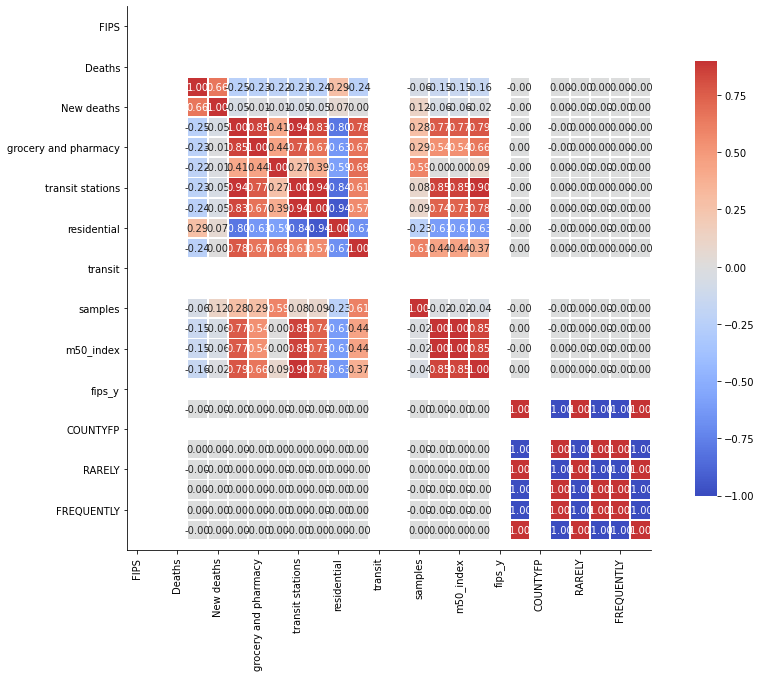

In [232]:
corr = queens_all_combined.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=.9, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

## Pending work

- merged_socialDistancing and merged_mobility to be concatenated 
- add population and population density as two columns
- mask as one column
- In the final merged dataframe, try gini-index, PCA to determine the key features
- final modeling V1

- Overlap m50 with covid cases 
- Mask data doesn't have time series ; Take the value 
- Mobility data- 8 diff types of data; walking =0; workplace- high; residential - high-> plot

In [ ]:
merged.dtypes